In [1]:
import zipfile
import os

zip_path = r"C:\Users\amarn\Downloads\archive.zip"  # Corrected file path
extract_path = r"C:\Users\amarn\brain_tumour\MRI Images"  # Destination folder

# Create extraction directory if not exists
os.makedirs(extract_path, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extraction completed! Files are saved in {extract_path}")


Extraction completed! Files are saved in C:\Users\amarn\brain_tumour\MRI Images


In [2]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the d
import matplotlib.pyplot as plt

In [3]:
# directories for training and testing data
train_dir = 'C:/Users/amarn/brain_tumour/MRI Images/Training'
test_dir = 'C:/Users/amarn/brain_tumour/MRI Images/Testing'
#load and shuffle the train data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir,label,image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths,train_labels)

#load and shuffle the test data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir,label,image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths,test_labels)


Data Visualizations


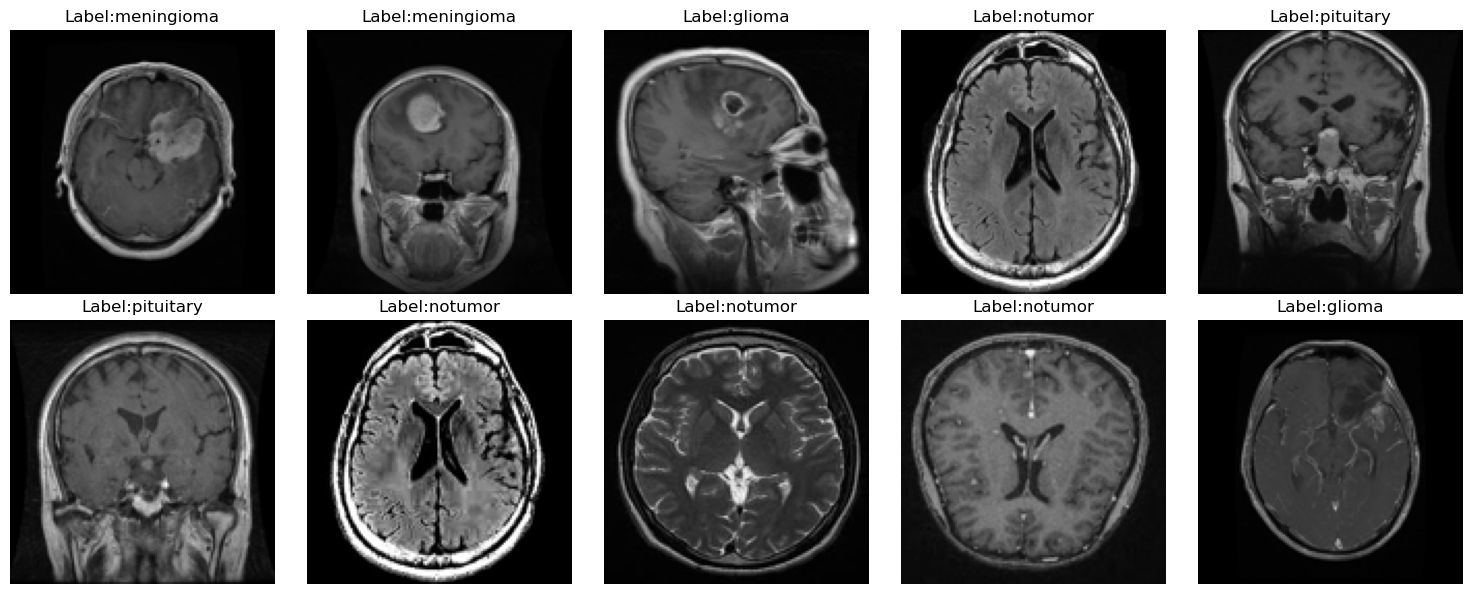

In [4]:
import random
import matplotlib.pyplot as plt

#select random indices for 10 images
random_indices = random.sample(range(len(train_paths)),10)

#create a figure to display images in two row
fig, axes = plt.subplots(2,5, figsize=(15,6))
axes = axes.ravel()

#loop through the random indices and dispplay images
for i, idx in enumerate(random_indices):
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((128,128))
    
    #display images
    axes[i].imshow(img, cmap='grey')
    axes[i].set_title(f"Label:{train_labels[idx]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Image Preprocessing


Model

In [5]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from PIL import Image, ImageEnhance
import numpy as np
import os
import random

# Constants
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
batch_size = 32
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 30

# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels

# Load VGG16 base model
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model except the last 4
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Define the model
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = base_model(inputs, training=False)  # Add base model
x = Flatten()(x)  # Flatten the output of the base model
x = Dropout(0.3)(x)  # Dropout layer for regularization
x = Dense(128, activation='relu')(x)  # Dense layer with ReLU activation
x = Dropout(0.2)(x)  # Dropout layer for regularization
outputs = Dense(len(os.listdir(train_dir)), activation='softmax')(x)  # Output layer with softmax activation

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Train the model using the custom data generator
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=50)

# Save the model
model.save('model.h5')

# Load the model from the Keras format
loaded_model = load_model('model.h5')

# Check the model's architecture
loaded_model.summary()


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - loss: 1.0803 - sparse_categorical_accuracy: 0.5291
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - loss: 0.4146 - sparse_categorical_accuracy: 0.8382
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - loss: 0.3667 - sparse_categorical_accuracy: 0.8523
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - loss: 0.3174 - sparse_categorical_accuracy: 0.8795
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - loss: 0.2894 - sparse_categorical_accuracy: 0.8944
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - loss: 0.2089 - sparse_categorical_accuracy: 0.9202
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - loss: 0.1782 - sparse_categorical_accuracy: 0.9314
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - loss: 0.1797 - sparse_categorical_accuracy: 0.9248
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - loss: 0.1449 - sparse_categorical_accuracy: 0.9449
Epoch 10/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - loss: 0.1703 - spars

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,763,910 (60.13 MB)

 Trainable params: 8,128,644 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 2 (12.00 B)

Train and Val Plots

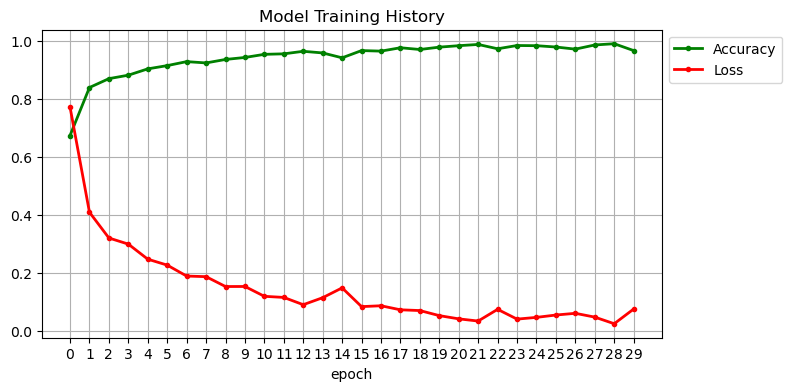

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'],'.g-', linewidth=2)
plt.plot(history.history['loss'],'.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch') 
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy','Loss'],loc='upper left',bbox_to_anchor=(1,1))
plt.show()

Model classification report

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))



41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 857ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       300
           1       0.96      0.89      0.93       306
           2       1.00      1.00      1.00       405
           3       1.00      0.97      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



Model confusion plot

Confusion Matrix:
[[294   6   0   0]
 [ 33 272   0   1]
 [  0   0 405   0]
 [  5   4   0 291]]


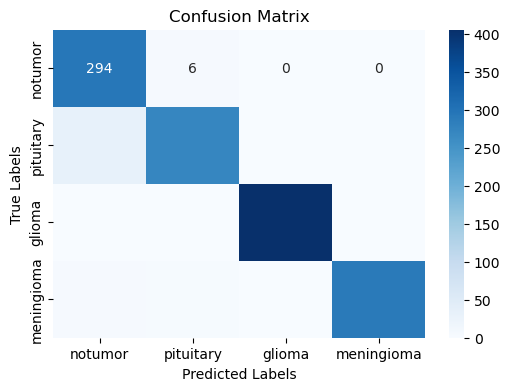

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming class_names contains the correct label names
class_labels = {'glioma','pituitary', 'notumor', 'meningioma'}
  # Replace with actual class names

# Compute Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Roc curve plot

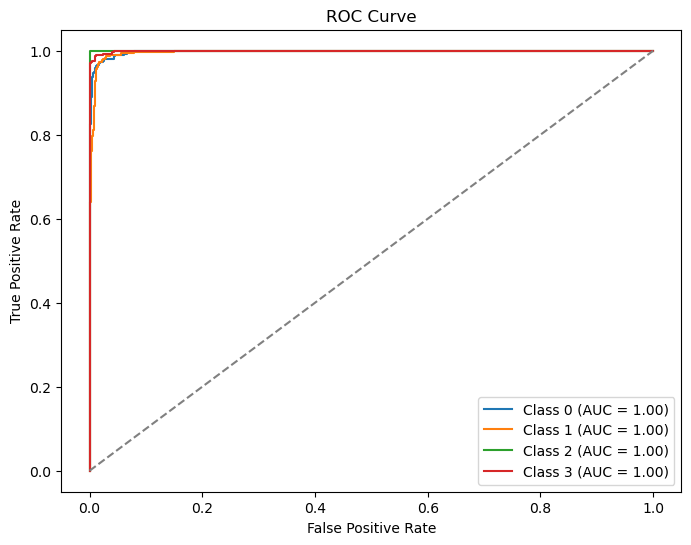

In [9]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

save and load model

In [10]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']


def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


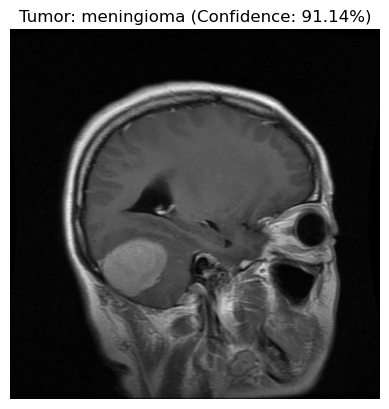

In [11]:
image_path = 'C:/Users/amarn/brain_tumour/MRI Images/Testing/meningioma/Te-me_0277.jpg'
detect_and_display(image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


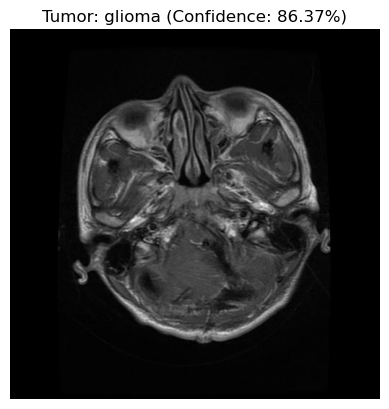

In [12]:
image_path = 'C:/Users/amarn/brain_tumour/MRI Images/Testing/glioma/Te-gl_0029.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


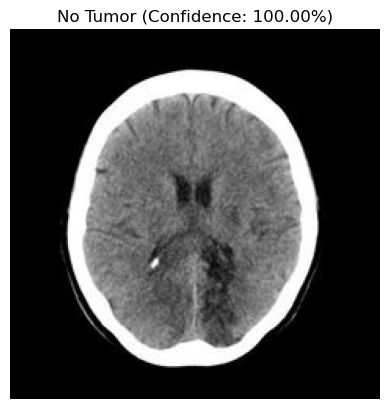

In [13]:
image_path = 'C:/Users/amarn/brain_tumour/MRI Images/Testing/notumor/Te-no_0012.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


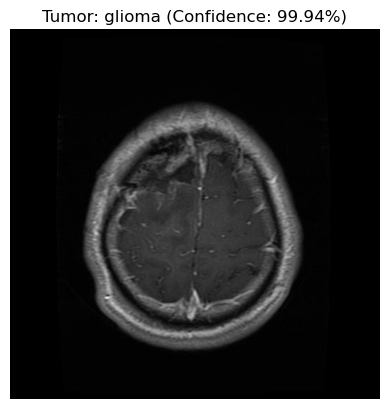

In [14]:
image_path = 'C:/Users/amarn/brain_tumour/MRI Images/Testing/glioma/Te-gl_0017.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


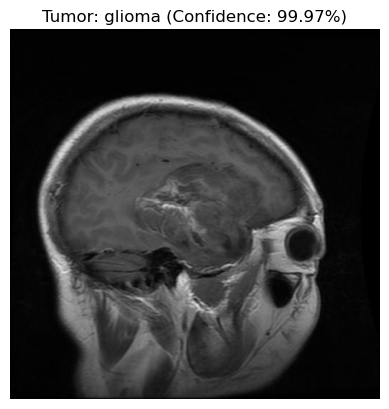

In [15]:
image_path = 'C:/Users/amarn/brain_tumour/MRI Images/Testing/glioma/Te-gl_0269.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


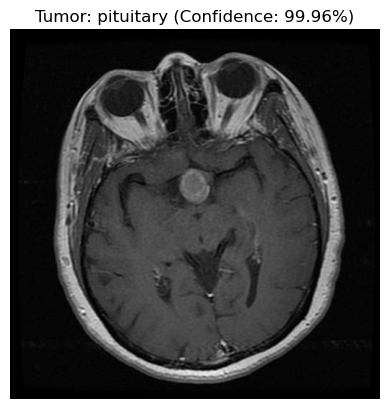

In [16]:
image_path = 'C:/Users/amarn/brain_tumour/MRI Images/Testing/pituitary/Te-pi_0015.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

In [ ]:
image_path = 'C:/Users/amarn/brain_tumour/MRI Images/Testing/pituitary/Te-pi_0256.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
